In [5]:
import pandas as pd
import re
import nltk
import os
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

nltk_data_dir = "./nltk_data"
nltk.data.path.append(nltk_data_dir)
os.makedirs(nltk_data_dir, exist_ok=True)

nltk.download('punkt', download_dir=nltk_data_dir, quiet=True)
nltk.download('punkt_tab', download_dir=nltk_data_dir, quiet=True)
nltk.download('wordnet', download_dir=nltk_data_dir, quiet=True)
nltk.download('omw-1.4', download_dir=nltk_data_dir, quiet=True)
nltk.download('averaged_perceptron_tagger_eng', download_dir=nltk_data_dir, quiet=True)
nltk.download('stopwords', download_dir=nltk_data_dir, quiet=True)

True

In [6]:
input_file = "../dataset/OBC_Cleaned.csv"

df = pd.read_csv(input_file)
df = df.dropna(how="all")

print(f"Loaded {len(df)} rows")
print(f"\nColumns: {list(df.columns)}")

Loaded 43389 rows

Columns: ['Trial_ID', 'Date', 'Defendant_Gender', 'Num_Defendants', 'Victim_Gender', 'Num_Victims', 'Offence', 'Offence_Subcategory', 'Verdict', 'Text_Length', 'Year', 'Trial_Text']


In [ ]:
df_cleaned = df.copy()

print("="*50)
print("DATA CLEANING COMPLETE")
print("="*50)
print(f"\nTotal rows: {len(df_cleaned)}")
print(f"\nVerdict distribution:\n{df_cleaned['Verdict'].value_counts()}")
print(f"\nOffence distribution:\n{df_cleaned['Offence'].value_counts()}")


DATA CLEANING COMPLETE

Total rows: 43389

Verdict distribution:
Verdict
guilty       31253
notGuilty    12136
Name: count, dtype: int64

Offence distribution:
Offence
theft            35684
violentTheft      2410
deception         1436
breakingPeace     1204
sexual            1069
kill              1050
royalOffences      234
miscellaneous      152
damage             150
Name: count, dtype: int64


In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def clean_text_advanced(text):
    try:
        if not isinstance(text, str):
            return ""
        text = re.sub(r'^\s*[TM]\.\s*', '', text)
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = re.sub(r'\b\w{1,2}\b', '', text)

        sentences = sent_tokenize(text)
        cleaned_sentences = []

        for sentence in sentences:
            words = word_tokenize(sentence.lower())
            words = [word for word in words if word not in stop_words]
            tagged_words = pos_tag(words)
            lemmatized_words = [
                lemmatizer.lemmatize(word, get_wordnet_pos(tag))
                for word, tag in tagged_words
            ]
            cleaned_sentences.append(" ".join(lemmatized_words))

        return " ".join(cleaned_sentences)
    except Exception as e:
        print(f"[ERROR] {e}")
        return text

df["Trial_Text"] = df["Trial_Text"].astype(str).apply(clean_text_advanced)

print("Advanced text cleaning complete")


Advanced text cleaning complete


In [ ]:
def clean_text_basic(text):
    text = str(text)
    text = re.sub(r'^[\W\d\s]+', '', text)
    text = re.sub(r'[+*FO]+', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def clean_text_punctuation(text):
    if pd.isna(text):
        return ""
    text = re.sub(r'(?<=\w)\.(?=[A-Z])', '. ', text)
    text = re.sub(r'\s+([.,!?])', r'\1', text)
    text = re.sub(r"Prisoner s", "Prisoner's", text)
    text = re.sub(r'(\d+)\s*d\s*\.', r'\1d.', text)
    return text.strip()

df['Trial_Text'] = df['Trial_Text'].apply(clean_text_basic)
df['Trial_Text'] = df['Trial_Text'].apply(clean_text_punctuation)

print("Basic text cleaning complete")


✓ Basic text cleaning complete


In [11]:
df_not_guilty = df[df['Verdict'] == 'notGuilty']
df_guilty = df[df['Verdict'] == 'guilty']

total_not_guilty = len(df_not_guilty)
total_guilty = len(df_guilty)
min_count = min(total_not_guilty, total_guilty)

print(f"Before balancing:")
print(f"  notGuilty: {total_not_guilty}")
print(f"  guilty: {total_guilty}")

df_not_guilty_balanced = df_not_guilty.sample(n=min_count, random_state=42)
df_guilty_balanced = df_guilty.sample(n=min_count, random_state=42)

df = pd.concat([df_not_guilty_balanced, df_guilty_balanced])

print(f"\nAfter balancing: {len(df)} rows")
print(f"\n{df['Verdict'].value_counts()}")

Before balancing:
  notGuilty: 12136
  guilty: 31253

After balancing: 24272 rows

Verdict
notGuilty    12136
guilty       12136
Name: count, dtype: int64


In [ ]:
df = df.drop_duplicates(subset="Trial_ID", keep="first")
df = df.drop_duplicates(subset="Trial_Text", keep="first")
df = df.drop(columns=["Date"])
df = df[df["Offence"] != "Unknown"]

print(f"After removing duplicates: {len(df)} rows")
print(f"\nVerdict distribution:\n{df['Verdict'].value_counts()}")


After removing duplicates: 24271 rows

Verdict distribution:
Verdict
notGuilty    12136
guilty       12135
Name: count, dtype: int64


In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import os
os.environ["WANDB_DISABLED"] = "true"

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using NVIDIA GPU (CUDA)")
else:
    device = torch.device("cpu")
    print("Using CPU")

print(f"Device: {device}")


/opt/anaconda3/envs/skripsi/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using Apple Silicon GPU (MPS)
Device: mps


In [14]:
df = df_cleaned[df_cleaned["Verdict"].isin(["guilty", "notGuilty"])].copy()
label_map = {"guilty": 1, "notGuilty": 0}
df["Label"] = df["Verdict"].map(label_map)
df["Formatted_Text"] = df.apply(lambda row: f"Year: {row['Year']} Text: {row['Trial_Text']}", axis=1)

print(f"Total samples for training: {len(df)}")
print(f"Label distribution:\n{df['Label'].value_counts()}")

Total samples for training: 43389
Label distribution:
Label
1    31253
0    12136
Name: count, dtype: int64


In [15]:
class CourtDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_len)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [16]:
def compute_metrics(eval_pred):
  logits, labels = eval_pred
  preds = np.argmax(logits, axis=1)
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc}

In [17]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [18]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
best_fold = -1
best_model = None
best_tokenizer = None
best_val_acc = 0.0
train_acc_all, val_acc_all = [], []
train_loss_all, val_loss_all = [], []


Fold 1


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/anaconda3/envs/skripsi/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.382200,0.154129,0.934778
2,0.149900,0.125850,0.947453
3,0.125500,0.116624,0.949297
4,0.109000,0.117183,0.949067
5,0.096700,0.113252,0.952063


/opt/anaconda3/envs/skripsi/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/envs/skripsi/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/envs/skripsi/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/envs/skripsi/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/envs/skripsi/lib/python3.12/site-packages/tor

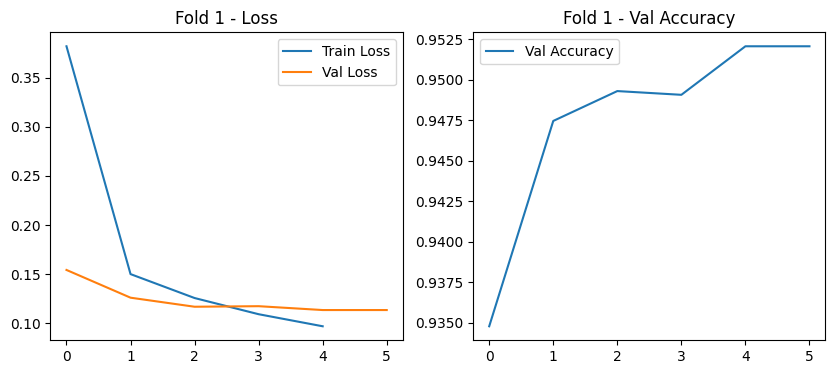


Fold 2


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/anaconda3/envs/skripsi/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.411200,0.158864,0.935239
2,0.152000,0.130390,0.944227
3,0.124000,0.121688,0.946762
4,0.109000,0.116308,0.948836
5,0.097400,0.113391,0.945840


/opt/anaconda3/envs/skripsi/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/envs/skripsi/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/envs/skripsi/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/envs/skripsi/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/envs/skripsi/lib/python3.12/site-packages/tor

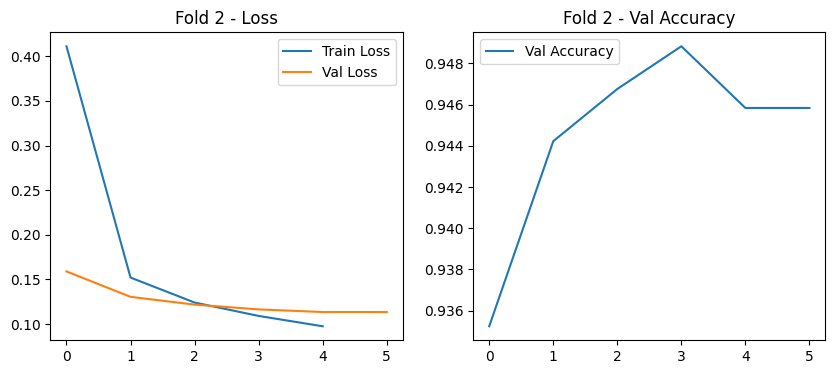


Fold 3


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/anaconda3/envs/skripsi/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
for fold, (train_idx, val_idx) in enumerate(kfold.split(df["Formatted_Text"], df["Label"])):
    print(f"\nFold {fold+1}")

    train_texts = df.iloc[train_idx]["Formatted_Text"].tolist()
    train_labels = df.iloc[train_idx]["Label"].tolist()
    val_texts = df.iloc[val_idx]["Formatted_Text"].tolist()
    val_labels = df.iloc[val_idx]["Label"].tolist()

    train_dataset = CourtDataset(train_texts, train_labels, tokenizer)
    val_dataset = CourtDataset(val_texts, val_labels, tokenizer)

    model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

    training_args = TrainingArguments(
        output_dir=f"./temp_fold_{fold}",
        num_train_epochs=5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        gradient_accumulation_steps=16,
        eval_strategy="epoch",
        save_strategy="no",
        logging_strategy="epoch",
        learning_rate=2e-5,
        report_to="none",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        warmup_steps=500,
        load_best_model_at_end=False,
        use_cpu=False,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
    )

    trainer.train()

    metrics = trainer.evaluate()
    val_acc_all.append(metrics["eval_accuracy"])
    val_loss_all.append(metrics["eval_loss"])

    logs = trainer.state.log_history
    train_loss = [log["loss"] for log in logs if "loss" in log]
    val_loss = [log["eval_loss"] for log in logs if "eval_loss" in log]
    val_acc = [log["eval_accuracy"] for log in logs if "eval_accuracy" in log]

    train_acc_all.append(logs[-1].get("accuracy", np.nan))
    train_loss_all.append(train_loss[-1] if train_loss else np.nan)

    if fold == 9:
      best_val_acc = metrics["eval_accuracy"]
      best_fold = fold
      best_model = model
      best_tokenizer = tokenizer

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Val Loss")
    plt.title(f"Fold {fold+1} - Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_acc, label="Val Accuracy")
    plt.title(f"Fold {fold+1} - Val Accuracy")
    plt.legend()
    plt.show()

    del model
    if torch.backends.mps.is_available():
        torch.mps.empty_cache()
    elif torch.cuda.is_available():
        torch.cuda.empty_cache()


In [ ]:
final_model_path = "./roberta_final_best_model"
os.makedirs(final_model_path, exist_ok=True)
best_model.save_pretrained(final_model_path)
best_tokenizer.save_pretrained(final_model_path)

In [ ]:
print("\nFinal model saved from best fold:", best_fold + 1)
print(f"Mean Validation Accuracy (10-fold): {np.mean(val_acc_all):.4f}")
print(f"Mean loss train (10-fold): {np.mean(train_loss_all):.4f}")
print(f"Mean loss val (10-fold): {np.mean(val_loss_all):.4f}")